In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [10]:
from local_explanations import *
import utils
import models

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

import torch
import torch_geometric.transforms as T
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

from collections import defaultdict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### read data

In [11]:
DATASET_NAME = "BAMultiShapes"

In [12]:
adjs_train , \
edge_weights_train , \
ori_classes_train , \
belonging_train , \
summary_predictions_train , \
le_classes_train = read_bamultishapes(evaluate_method=True, 
                                       remove_mix=False, 
                                       min_num_include=5, 
                                       split="TRAIN") #, manual_cut=0.47377795

print(len(adjs_train) , len(edge_weights_train), len(ori_classes_train) , len(belonging_train))
print(np.unique(summary_predictions_train["wrong"], return_counts=True) , np.unique(summary_predictions_train["correct"], return_counts=True))
print(np.unique(le_classes_train, return_counts=True))

Num shapes: 1032, Num Preserved: 1024, Ratio: 0.992, Num Multipleshapes: 305
num_class_relationship_broken:  7  num_multi_shapes_removed: 0
970 970 800 970
(array([], dtype=float64), array([], dtype=int64)) (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 34,  42,  45, 242, 124, 139, 137,  37], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([121, 162, 157, 251,  78, 102,  73,  26], dtype=int64))


In [7]:
print(np.unique(summary_predictions_train["wrong"], return_counts=True))
print(np.unique(summary_predictions_train["correct"], return_counts=True))

(array([], dtype=float64), array([], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 34,  42,  45, 242, 124, 139, 137,  37], dtype=int64))


In [6]:
sum([6,  3, 37, 34, 36,  45, 242, 124, 136, 137])

800

In [7]:
34 / 40

0.85

In [8]:
bamultishapes2_classes_names[1] , bamultishapes2_classes_names[5] , bamultishapes2_classes_names[7]

('grid', 'house+wheel', 'all')

In [9]:
bamultishapes2_classes_names

['house',
 'grid',
 'wheel',
 'ba',
 'house+grid',
 'house+wheel',
 'wheel+grid',
 'all']

In [5]:
adjs_val , \
edge_weights_val , \
ori_classes_val , \
belonging_val , \
summary_predictions_val , \
le_classes_val = read_bamultishapes(evaluate_method=True, 
                                     remove_mix=False, 
                                     min_num_include=5, 
                                     split="VAL") #, manual_cut=0.47377795

print(len(adjs_val) , len(edge_weights_val), len(ori_classes_val) , len(belonging_val))
print(np.unique(summary_predictions_val["wrong"], return_counts=True) , np.unique(summary_predictions_val["correct"], return_counts=True))
print(np.unique(le_classes_val, return_counts=True))

Num shapes: 127, Num Preserved: 127, Ratio: 1.0, Num Multipleshapes: 43
num_class_relationship_broken:  0  num_multi_shapes_removed: 0
115 115 100 115
(array([], dtype=float64), array([], dtype=int64)) (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 2,  6,  7, 31, 10, 20, 20,  4], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 9, 14, 19, 31, 10, 16, 15,  1], dtype=int64))


In [6]:
adjs_test , \
edge_weights_test , \
ori_classes_test , \
belonging_test , \
summary_predictions_test , \
le_classes_test = read_bamultishapes(evaluate_method=True, 
                                      remove_mix=False, 
                                      min_num_include=5, 
                                      split="TEST") #, manual_cut=0.47377795

print(len(adjs_test) , len(edge_weights_test), len(ori_classes_test) , len(belonging_test))
print(np.unique(summary_predictions_test["wrong"], return_counts=True) , np.unique(summary_predictions_test["correct"], return_counts=True))
print(np.unique(le_classes_test, return_counts=True))

Num shapes: 119, Num Preserved: 118, Ratio: 0.992, Num Multipleshapes: 31
num_class_relationship_broken:  1  num_multi_shapes_removed: 0
120 120 100 120
(array([], dtype=float64), array([], dtype=int64)) (array([0, 1, 2, 3, 4, 5, 6]), array([ 7,  5,  7, 31, 17, 14, 19], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([17, 21, 18, 33,  9, 11, 11], dtype=int64))


### dataset

C:\Users\Steve\Desktop\GNN\gnn_logic_global_expl\code\utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr=torch.tensor(t.weight).reshape(-1, 1),


(array([0, 1, 2, 3, 4, 5, 6, 7]), array([121, 162, 157, 251,  78, 102,  73,  26], dtype=int64))
(tensor([0, 1]), tensor([369, 601]))


('grid', 12, tensor([12]))

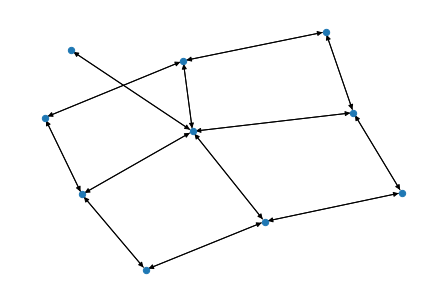

In [7]:
device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
])     


dataset_train = utils.LocalExplanationsDataset("", adjs_train, edge_weights_train, "same", transform=transform, y=le_classes_train, belonging=belonging_train, task_y=ori_classes_train)
dataset_val = utils.LocalExplanationsDataset("", adjs_val, edge_weights_val, "same", transform=transform, y=le_classes_val, belonging=belonging_val, task_y=ori_classes_val)
dataset_test = utils.LocalExplanationsDataset("", adjs_test, edge_weights_test, "same", transform=transform, y=le_classes_test, belonging=belonging_test, task_y=ori_classes_test)


##
# debug Dataset
##
print(np.unique(le_classes_train, return_counts=True))
print(torch.unique(dataset_train.data.task_y, return_counts=True))
idx = 18
nx.draw(to_networkx(dataset_train[idx]), node_size=40)   # debug Dataset
bamultishapes_classes_names[dataset_train[idx].y] , belonging_train[idx] , dataset_train[idx].graph_id

### Run the model

(array([0., 1., 2., 3., 4., 5., 6., 7.], dtype=float32), array([121, 162, 157, 251,  78, 102,  73,  26], dtype=int64))


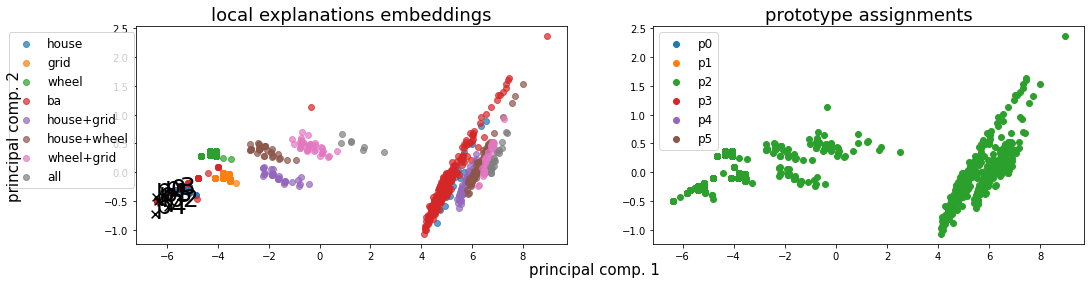

Alpha norms:
tensor([[0.9595, 1.0000, 0.9094, 0.7717, 0.9062, 0.8726],
        [0.8822, 0.8649, 0.8276, 1.0000, 0.9040, 0.7665]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.258763 +- 0.000000
Concept distribution:  (array([2], dtype=int64), array([970], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.24247, LEN: 0.088341, AccxC: 0.48, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.24807, V. LEN 0.10
  2: Loss: 0.18472, LEN: 0.087954, AccxC: 0.54, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.19910, V. LEN 0.10
  3: Loss: 0.14765, LEN: 0.087587, AccxC: 0.54, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18689, V. LEN 0.10
  4: Loss: 0.14446, LEN: 0.087135, AccxC: 0.51, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.17576, V. LEN 0.10
  5: Loss: 0.13422, LEN: 0.086768, AccxC: 0.50, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.16677, V. LEN 0.10
  6: Loss: 0.12541, LEN: 0.086424, AccxC: 0.52, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.16157, V.

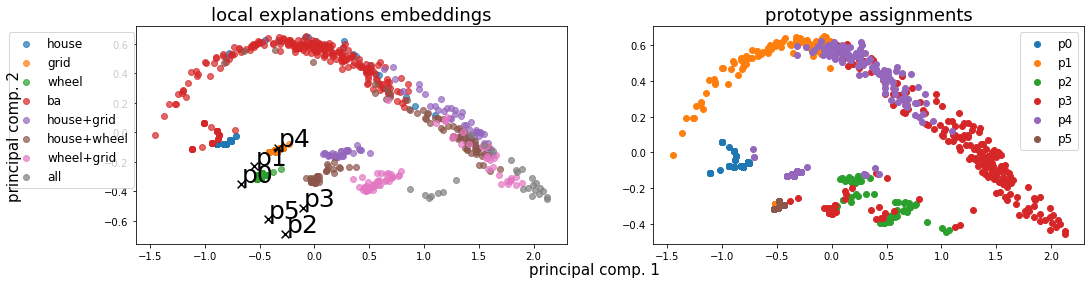

Alpha norms:
tensor([[0.9819, 1.0000, 0.9704, 0.8777, 0.9679, 0.9615],
        [1.0000, 0.6583, 0.7893, 0.9588, 0.8183, 0.7872]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.626616 +- 0.227373
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([133, 113, 119, 224, 240, 141], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)


 20: Loss: 0.09804, LEN: 0.080409, AccxC: 0.60, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.12829, V. LEN 0.09
 21: Loss: 0.09388, LEN: 0.079907, AccxC: 0.65, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.12776, V. LEN 0.09
 22: Loss: 0.09444, LEN: 0.079457, AccxC: 0.63, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.12282, V. LEN 0.09
 23: Loss: 0.09229, LEN: 0.078941, AccxC: 0.64, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.12026, V. LEN 0.09
 24: Loss: 0.09234, LEN: 0.078494, AccxC: 0.63, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.11622, V. LEN 0.09
 25: Loss: 0.09139, LEN: 0.078024, AccxC: 0.62, AccO:

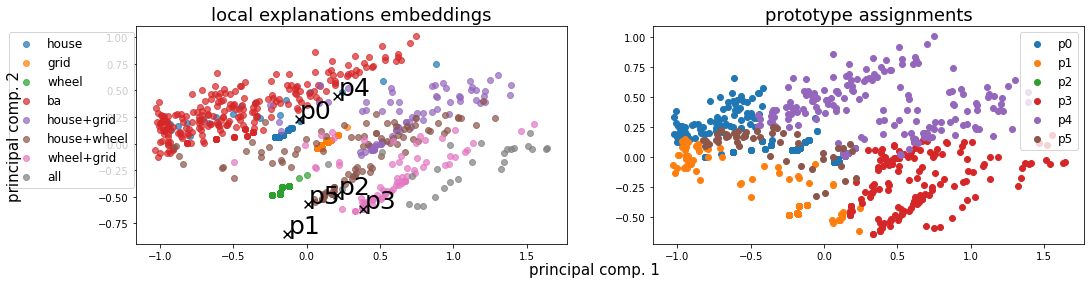

Alpha norms:
tensor([[0.7070, 0.8274, 0.7442, 1.0000, 0.7442, 0.6615],
        [0.7174, 0.3635, 1.0000, 0.8416, 0.6732, 0.6388]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.477599 +- 0.136439
Concept distribution:  (array([0, 1, 3, 4, 5], dtype=int64), array([322, 220, 153, 225,  50], dtype=int64))
Logic formulas:
For class 0:
0.51875 (feature001) | (feature000 & feature001)
For class 1:
0.6025 (feature000) | (feature003) | (feature004) | (feature005) | (feature004 & feature000) | (feature005 & feature004) | (feature005 & feature000) | (feature000 & feature003) | ((feature001 & feature004) | ((feature001 & feature000) | ((feature001 & feature003) | (feature004 & feature003)

------------------------------------------------------------------------------------
Has double activations  tensor(69)
But only for wrong predictions

Accuracy as classifier:  0.5175
LEN fidelity:  tensor(0.4762)


 40: Loss: 0.08134, LEN: 0.072785, AccxC: 0.62, AccO: 0.62, V. Acc: 0.54, V. Loss: 0.10410, V.

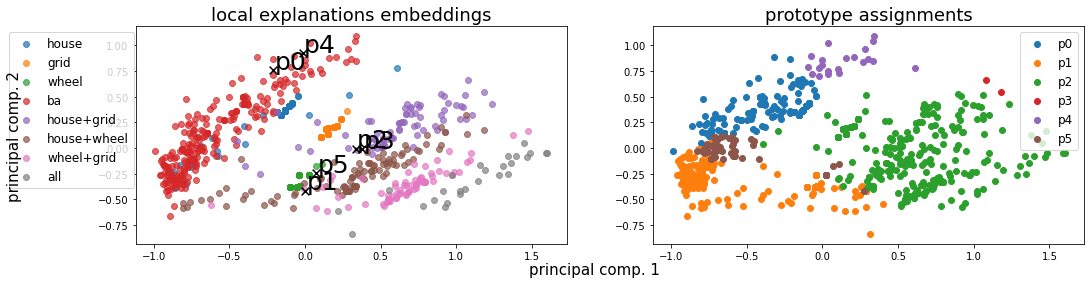

Alpha norms:
tensor([[0.3767, 0.4678, 0.5321, 1.0000, 0.3836, 0.3300],
        [0.2602, 0.1921, 0.9592, 1.0000, 0.3640, 0.2741]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.661980 +- 0.229950
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([206, 282, 395,   2,  21,  64], dtype=int64))
Logic formulas:
For class 0:
0.82125 (feature001) | (feature000) | (feature000 & feature001) | ((feature005)
For class 1:
0.795 (feature002) | (feature005) | (feature000 & feature002) | (feature000 & feature005) | (feature005 & feature002) | ((feature001 & feature002) | (feature003)

------------------------------------------------------------------------------------
Has double activations  tensor(48)
But only for wrong predictions

Accuracy as classifier:  0.765
LEN fidelity:  tensor(0.7600)


------------------------------------------------------------------------------------
Has double activations  tensor(5)
But only for wrong predictions


 60: Loss: 0.07024, LEN: 0.065292,

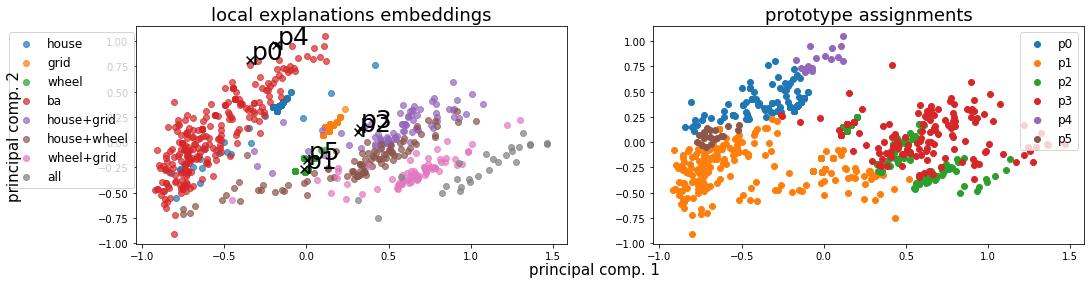

Alpha norms:
tensor([[0.2974, 0.3008, 0.5594, 1.0000, 0.2881, 0.2586],
        [0.1227, 0.0920, 0.8350, 1.0000, 0.2128, 0.1557]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.645786 +- 0.266649
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([179, 366, 223, 165,  17,  20], dtype=int64))
Logic formulas:
For class 0:
0.81125 (feature001) | (feature000) | (feature000 & feature001) | ((feature005)
For class 1:
0.8325 (feature002) | (feature003) | (feature000 & feature002) | (feature000 & feature003) | ((feature001 & feature002) | ((feature001 & feature003)
Accuracy as classifier:  0.8112
LEN fidelity:  tensor(0.7862)


 80: Loss: 0.06028, LEN: 0.056631, AccxC: 0.75, AccO: 0.69, V. Acc: 0.78, V. Loss: 0.07098, V. LEN 0.06
 81: Loss: 0.06066, LEN: 0.057246, AccxC: 0.75, AccO: 0.71, V. Acc: 0.84, V. Loss: 0.06254, V. LEN 0.06
 82: Loss: 0.05720, LEN: 0.053716, AccxC: 0.76, AccO: 0.74, V. Acc: 0.83, V. Loss: 0.06537, V. LEN 0.06
 83: Loss: 0.06000, LEN: 0.057139, Accx

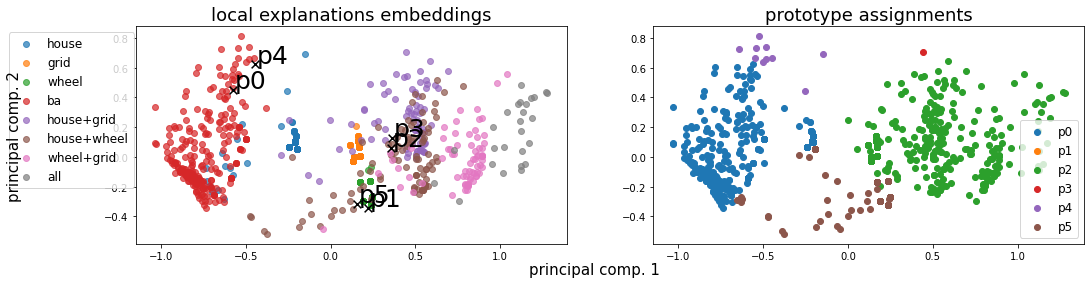

Alpha norms:
tensor([[0.3020, 0.2560, 0.5947, 1.0000, 0.2987, 0.2789],
        [0.1121, 0.0874, 0.8217, 1.0000, 0.1461, 0.1551]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.732570 +- 0.198450
Concept distribution:  (array([0, 2, 3, 4, 5], dtype=int64), array([339, 418,   1,  10, 202], dtype=int64))
Logic formulas:
For class 0:
0.8725 (feature000) | (feature005) | (feature005 & feature000) | (feature004)
For class 1:
0.8875 (feature002) | (feature005) | (feature000 & feature002) | (feature005 & feature002) | (feature000 & feature005) | (feature003)

------------------------------------------------------------------------------------
Has double activations  tensor(112)
But only for wrong predictions

Accuracy as classifier:  0.81
LEN fidelity:  tensor(0.7975)


------------------------------------------------------------------------------------
Has double activations  tensor(12)
But only for wrong predictions


100: Loss: 0.05564, LEN: 0.052724, AccxC: 0.75, AccO: 0.66, V. Acc: 0.7

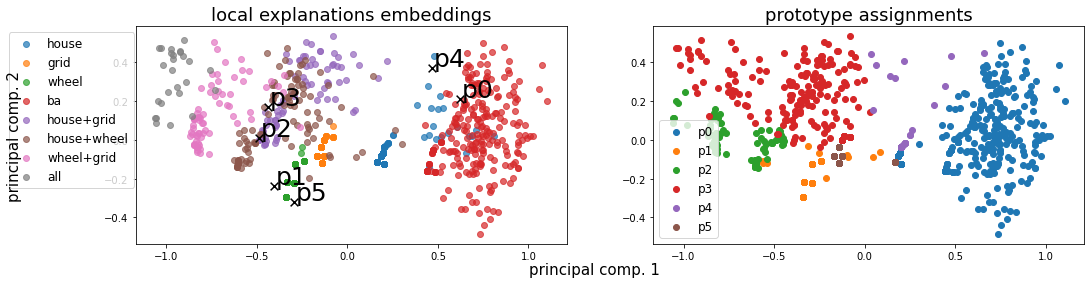

Alpha norms:
tensor([[0.3682, 0.3062, 0.6559, 1.0000, 0.3171, 0.3496],
        [0.1328, 0.1222, 1.0000, 0.9434, 0.1391, 0.1872]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.672594 +- 0.227141
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([332, 165,  95, 192,  28, 158], dtype=int64))
Logic formulas:
For class 0:
0.89125 (feature000) | ((feature001) | ((feature001 & feature000) | (feature004)
For class 1:
0.89125 (feature002) | (feature005) | (feature003) | (feature000 & feature005) | (feature000 & feature003) | (feature004 & feature003) | (feature005 & feature003) | (feature004 & feature005) | (feature005 & feature002) | (feature003 & feature002) | ((feature001 & feature005) | ((feature001 & feature003) | ((feature001 & feature004) | ((feature001 & feature002) | (feature000 & feature002)
Accuracy as classifier:  0.8912
LEN fidelity:  tensor(0.8913)


120: Loss: 0.04447, LEN: 0.041486, AccxC: 0.84, AccO: 0.85, V. Acc: 0.93, V. Loss: 0.03516, V. LEN 0.03
121:

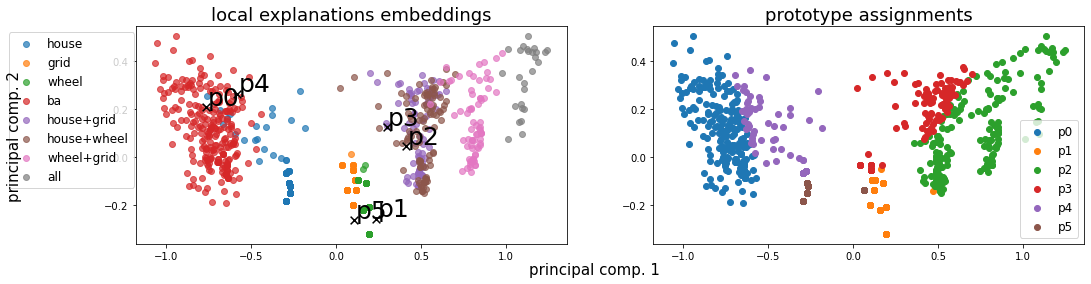

Alpha norms:
tensor([[0.4731, 0.3642, 0.8916, 1.0000, 0.3590, 0.4168],
        [0.1069, 0.1118, 1.0000, 0.6658, 0.1307, 0.1456]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.608072 +- 0.231459
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([219, 280, 193, 110,  69,  99], dtype=int64))
Logic formulas:
For class 0:
0.91375 (feature000) | (feature001) | ((feature004)
For class 1:
0.91375 (feature002) | (feature005) | (feature003) | (feature001 & feature005) | (feature001 & feature003) | (feature005 & feature003) | (feature004 & feature003) | (feature001 & feature004) | (feature001 & feature002) | (feature005 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.9138
LEN fidelity:  tensor(0.9137)


140: Loss: 0.03162, LEN: 0.029588, AccxC: 0.88, AccO: 0.87, V. Acc: 0.93, V. Loss: 0.02616, V. LEN 0.02
141: Loss: 0.03132, LEN: 0.029428, AccxC: 0.88, AccO: 0.88, V. Acc: 0.94, V. Loss: 0.02911, V. LEN 0.02
142: Loss: 0.03642, LEN: 0.034263, AccxC: 0.8

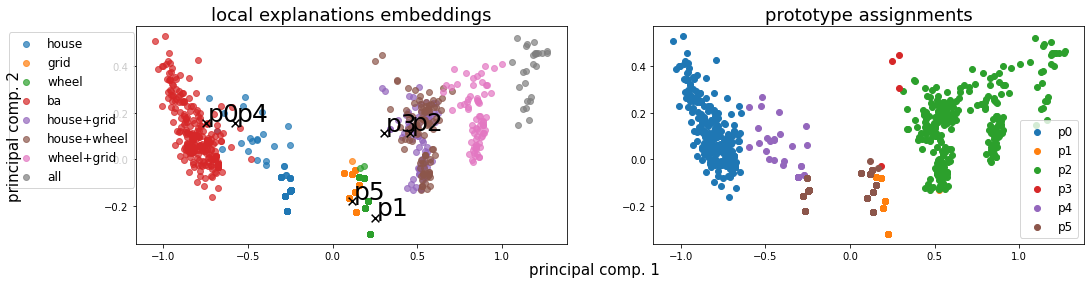

Alpha norms:
tensor([[0.4971, 0.3566, 1.0000, 0.8274, 0.3179, 0.4517],
        [0.0914, 0.1007, 1.0000, 0.4413, 0.0998, 0.1262]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.725918 +- 0.242331
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([251, 156, 275,   4,  32, 252], dtype=int64))
Logic formulas:
For class 0:
0.935 (feature000) | (feature001) | ((feature004)
For class 1:
0.935 (feature005) | (feature002) | (feature003) | (feature001 & feature005) | (feature004 & feature001) | (feature005 & feature003) | (feature004 & feature005) | (feature005 & feature002) | (feature001 & feature002)
Accuracy as classifier:  0.935
LEN fidelity:  tensor(0.9350)


160: Loss: 0.02759, LEN: 0.026179, AccxC: 0.89, AccO: 0.89, V. Acc: 0.95, V. Loss: 0.01832, V. LEN 0.02
161: Loss: 0.02508, LEN: 0.023575, AccxC: 0.91, AccO: 0.91, V. Acc: 0.86, V. Loss: 0.03611, V. LEN 0.03
162: Loss: 0.02523, LEN: 0.023656, AccxC: 0.92, AccO: 0.92, V. Acc: 0.93, V. Loss: 0.02270, V. LEN 0.02
16

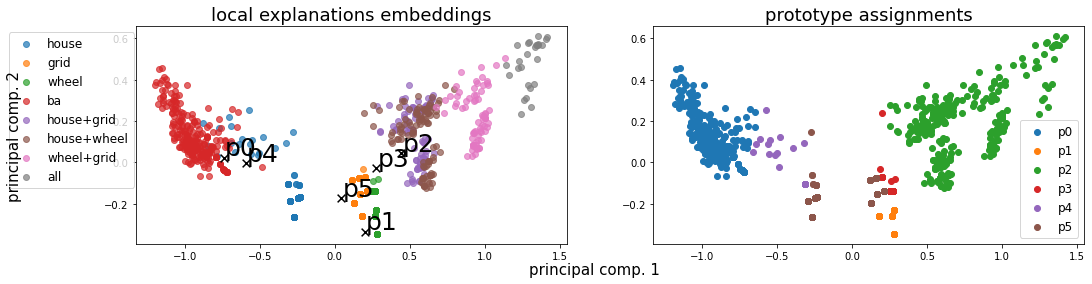

Alpha norms:
tensor([[0.4608, 0.3204, 1.0000, 0.6441, 0.2668, 0.4131],
        [0.0815, 0.0949, 1.0000, 0.3382, 0.0789, 0.1128]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.726046 +- 0.215482
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([257, 173, 278,  34,  21, 207], dtype=int64))
Logic formulas:
For class 0:
0.93875 (feature000) | (feature001) | ((feature004)
For class 1:
0.93875 (feature005) | (feature002) | (feature003) | (feature001 & feature005) | (feature005 & feature003) | (feature001 & feature003) | (feature005 & feature002) | (feature001 & feature002) | ((feature004 & feature003) | ((feature004 & feature001) | (feature003 & feature002)
Accuracy as classifier:  0.9388
LEN fidelity:  tensor(0.9388)


180: Loss: 0.02063, LEN: 0.019151, AccxC: 0.91, AccO: 0.91, V. Acc: 0.92, V. Loss: 0.02081, V. LEN 0.02
181: Loss: 0.02081, LEN: 0.019365, AccxC: 0.93, AccO: 0.93, V. Acc: 0.82, V. Loss: 0.03673, V. LEN 0.03
182: Loss: 0.02235, LEN: 0.021060, AccxC: 0

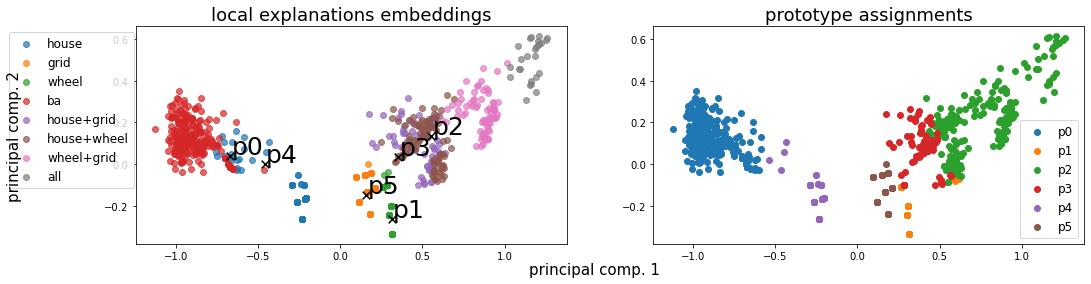

Alpha norms:
tensor([[0.4424, 0.3034, 1.0000, 0.5845, 0.2342, 0.3926],
        [0.0768, 0.0956, 1.0000, 0.2910, 0.0792, 0.0986]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.779473 +- 0.276103
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([267, 146, 213,  77, 105, 162], dtype=int64))
Logic formulas:
For class 0:
0.94125 (feature001) | (feature000) | ((feature004)
For class 1:
0.94125 (feature002) | (feature003) | (feature005) | (feature004 & feature005) | (feature001 & feature005) | (feature004 & feature001) | (feature004 & feature003) | (feature005 & feature003) | (feature004 & feature002) | (feature001 & feature002) | (feature001 & feature003) | (feature003 & feature002) | (feature005 & feature002)
Accuracy as classifier:  0.9412
LEN fidelity:  tensor(0.9413)


200: Loss: 0.01953, LEN: 0.018687, AccxC: 0.93, AccO: 0.93, V. Acc: 0.94, V. Loss: 0.01645, V. LEN 0.01
201: Loss: 0.01948, LEN: 0.018443, AccxC: 0.93, AccO: 0.93, V. Acc: 0.87, V. Loss: 0.02866, V

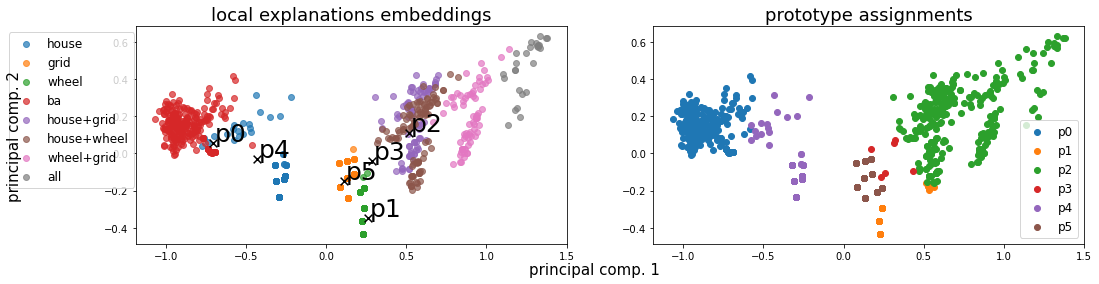

Alpha norms:
tensor([[0.4451, 0.3156, 1.0000, 0.5637, 0.2434, 0.4137],
        [0.0784, 0.1005, 1.0000, 0.2634, 0.0946, 0.1032]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.745983 +- 0.289131
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([256, 137, 270,   6, 116, 185], dtype=int64))
Logic formulas:
For class 0:
0.96125 (feature001) | (feature000) | (feature005) | ((feature004)
For class 1:
0.96125 (feature002) | (feature003) | (feature004 & feature005) | (feature001 & feature005) | (feature004 & feature001) | (feature005 & feature003) | (feature004 & feature002) | (feature001 & feature002) | (feature005 & feature002) | (feature001 & feature003)
Accuracy as classifier:  0.9612
LEN fidelity:  tensor(0.9613)


220: Loss: 0.02078, LEN: 0.019785, AccxC: 0.93, AccO: 0.93, V. Acc: 0.96, V. Loss: 0.01407, V. LEN 0.01
221: Loss: 0.01790, LEN: 0.017156, AccxC: 0.94, AccO: 0.94, V. Acc: 0.95, V. Loss: 0.01685, V. LEN 0.02
222: Loss: 0.01666, LEN: 0.015791, AccxC: 0.9

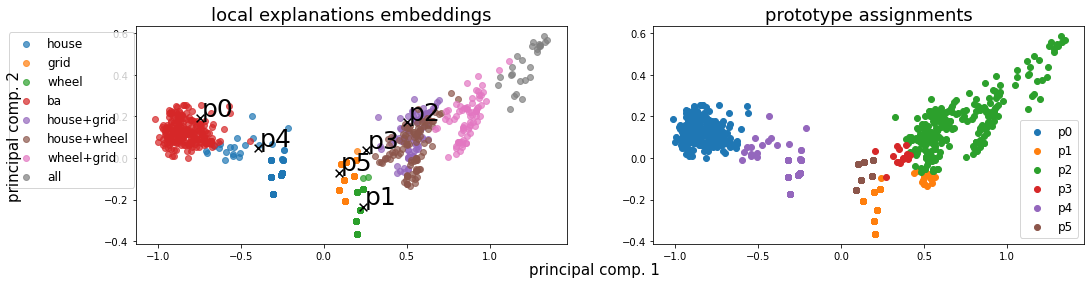

Alpha norms:
tensor([[0.4182, 0.3079, 1.0000, 0.5088, 0.2374, 0.3987],
        [0.0762, 0.1071, 1.0000, 0.2342, 0.1028, 0.0965]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.789330 +- 0.246070
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([255, 215, 249,  15, 117, 119], dtype=int64))
Logic formulas:
For class 0:
0.95125 (feature001) | (feature000) | (feature005) | ((feature004)
For class 1:
0.95125 (feature002) | (feature003) | (feature005 & feature004) | (feature004 & feature001) | (feature005 & feature001) | (feature005 & feature003) | (feature004 & feature002) | (feature001 & feature002) | (feature005 & feature002)
Accuracy as classifier:  0.9512
LEN fidelity:  tensor(0.9513)


240: Loss: 0.01631, LEN: 0.015645, AccxC: 0.96, AccO: 0.96, V. Acc: 0.89, V. Loss: 0.02742, V. LEN 0.03
241: Loss: 0.01605, LEN: 0.015399, AccxC: 0.95, AccO: 0.95, V. Acc: 0.97, V. Loss: 0.01175, V. LEN 0.01
242: Loss: 0.01478, LEN: 0.014139, AccxC: 0.96, AccO: 0.96, V. Acc: 0.96,

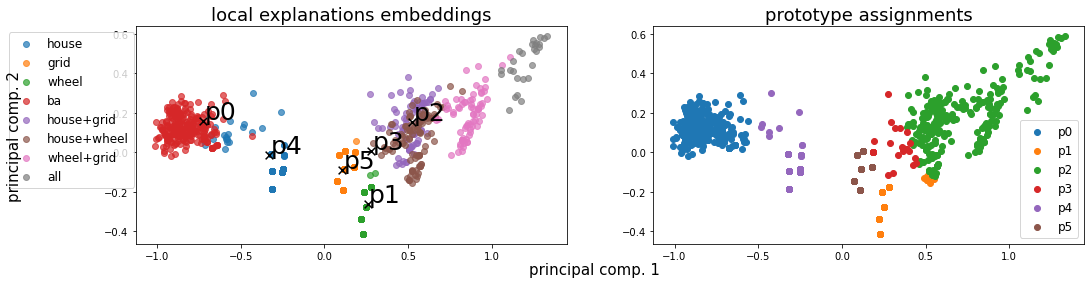

Alpha norms:
tensor([[0.4118, 0.3154, 1.0000, 0.4930, 0.2420, 0.4053],
        [0.0761, 0.1168, 1.0000, 0.2230, 0.1097, 0.0968]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.768742 +- 0.290696
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([264, 162, 255,  26, 108, 155], dtype=int64))
Logic formulas:
For class 0:
0.97375 (feature001) | (feature000) | (feature005) | ((feature004)
For class 1:
0.97375 (feature002) | (feature003) | (feature005 & feature004) | (feature005 & feature001) | (feature004 & feature001) | (feature001 & feature003) | (feature004 & feature003) | (feature005 & feature003) | (feature004 & feature002) | (feature001 & feature002) | (feature005 & feature002)
Accuracy as classifier:  0.9738
LEN fidelity:  tensor(0.9737)


260: Loss: 0.01362, LEN: 0.012935, AccxC: 0.96, AccO: 0.96, V. Acc: 0.97, V. Loss: 0.01162, V. LEN 0.01
261: Loss: 0.01345, LEN: 0.012951, AccxC: 0.97, AccO: 0.97, V. Acc: 0.96, V. Loss: 0.01367, V. LEN 0.01
262: Loss: 0.0143

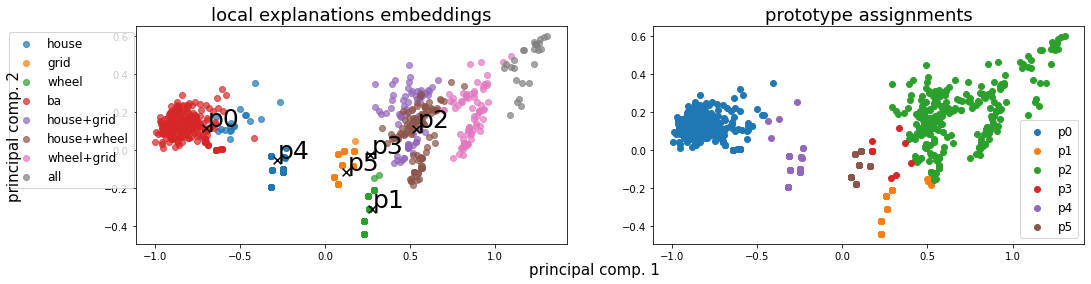

Alpha norms:
tensor([[0.3924, 0.3233, 1.0000, 0.4613, 0.2477, 0.4114],
        [0.0751, 0.1249, 1.0000, 0.2059, 0.1170, 0.0995]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.803503 +- 0.249128
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([267, 161, 270,  12, 105, 155], dtype=int64))
Logic formulas:
For class 0:
0.9725 (feature000) | (feature005) | (feature001) | ((feature004)
For class 1:
0.9725 (feature002) | (feature003) | (feature005 & feature004) | (feature005 & feature001) | (feature004 & feature001) | (feature001 & feature003) | (feature004 & feature003) | (feature005 & feature003) | (feature004 & feature002) | (feature001 & feature002) | (feature005 & feature002)
Accuracy as classifier:  0.9725
LEN fidelity:  tensor(0.9725)


280: Loss: 0.01467, LEN: 0.014217, AccxC: 0.96, AccO: 0.96, V. Acc: 0.98, V. Loss: 0.00913, V. LEN 0.01
281: Loss: 0.01382, LEN: 0.013303, AccxC: 0.95, AccO: 0.95, V. Acc: 0.96, V. Loss: 0.01371, V. LEN 0.01
282: Loss: 0.01266,

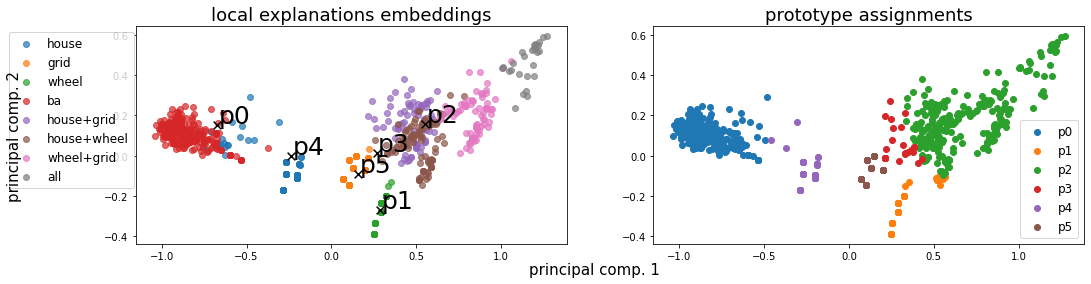

Alpha norms:
tensor([[0.3958, 0.3365, 1.0000, 0.4478, 0.2616, 0.4230],
        [0.0770, 0.1357, 1.0000, 0.1963, 0.1268, 0.1039]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.767792 +- 0.285667
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([268, 165, 253,  25, 104, 155], dtype=int64))
Logic formulas:
For class 0:
0.9725 (feature001) | (feature000) | (feature005) | ((feature004)
For class 1:
0.9725 (feature002) | (feature003) | (feature005 & feature004) | (feature005 & feature001) | (feature004 & feature001) | (feature001 & feature003) | (feature004 & feature003) | (feature004 & feature002) | (feature001 & feature002) | (feature005 & feature002)
Accuracy as classifier:  0.9725
LEN fidelity:  tensor(0.9725)


300: Loss: 0.01361, LEN: 0.013212, AccxC: 0.96, AccO: 0.96, V. Acc: 0.96, V. Loss: 0.01263, V. LEN 0.01
301: Loss: 0.01247, LEN: 0.012017, AccxC: 0.96, AccO: 0.96, V. Acc: 0.98, V. Loss: 0.00908, V. LEN 0.01
302: Loss: 0.01019, LEN: 0.009678, AccxC: 0.97,

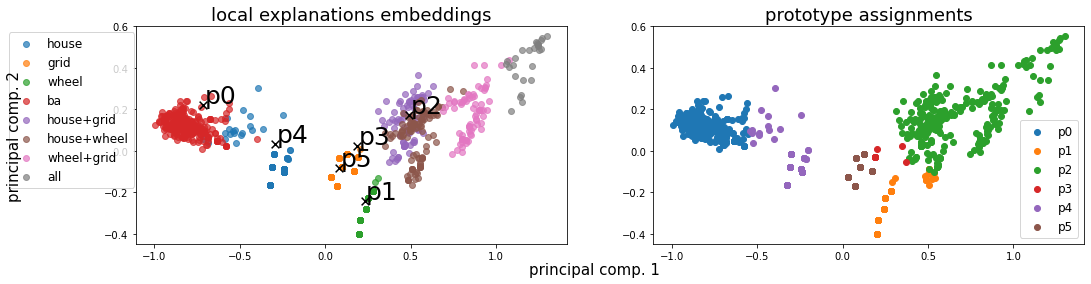

Alpha norms:
tensor([[0.4216, 0.3686, 1.0000, 0.4423, 0.2870, 0.4491],
        [0.0830, 0.1578, 1.0000, 0.1990, 0.1405, 0.1134]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.833118 +- 0.235724
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([257, 170, 264,   9, 115, 155], dtype=int64))
Logic formulas:
For class 0:
0.96875 (feature001) | (feature000) | (feature005) | ((feature004)
For class 1:
0.96875 (feature002) | (feature003) | (feature005 & feature004) | (feature005 & feature001) | (feature004 & feature001) | (feature001 & feature003) | (feature004 & feature003) | (feature004 & feature002) | (feature001 & feature002) | (feature005 & feature002)
Accuracy as classifier:  0.9688
LEN fidelity:  tensor(0.9688)


320: Loss: 0.01265, LEN: 0.012170, AccxC: 0.96, AccO: 0.96, V. Acc: 0.97, V. Loss: 0.01198, V. LEN 0.01
321: Loss: 0.01204, LEN: 0.011599, AccxC: 0.96, AccO: 0.96, V. Acc: 0.98, V. Loss: 0.00953, V. LEN 0.01
322: Loss: 0.01314, LEN: 0.012610, AccxC: 0.9

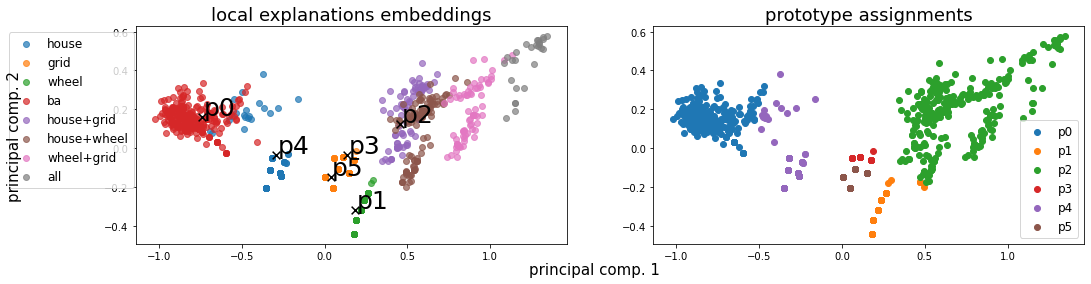

Alpha norms:
tensor([[0.4344, 0.3773, 1.0000, 0.4364, 0.2918, 0.4511],
        [0.0873, 0.1693, 1.0000, 0.2012, 0.1546, 0.1142]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.882598 +- 0.235585
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([257, 161, 275,  24, 115, 138], dtype=int64))
Logic formulas:
For class 0:
0.97625 (feature000) | (feature005) | (feature001) | ((feature004)
For class 1:
0.97625 (feature002) | (feature005 & feature004) | (feature005 & feature001) | (feature001 & feature003) | (feature004 & feature003) | (feature004 & feature001) | (feature004 & feature002) | (feature001 & feature002) | (feature003 & feature002) | (feature003)
Accuracy as classifier:  0.9762
LEN fidelity:  tensor(0.9762)


340: Loss: 0.01103, LEN: 0.010595, AccxC: 0.97, AccO: 0.97, V. Acc: 0.98, V. Loss: 0.00910, V. LEN 0.01
341: Loss: 0.01059, LEN: 0.010185, AccxC: 0.96, AccO: 0.96, V. Acc: 0.96, V. Loss: 0.01677, V. LEN 0.02
342: Loss: 0.01203, LEN: 0.011621, AccxC: 0.9

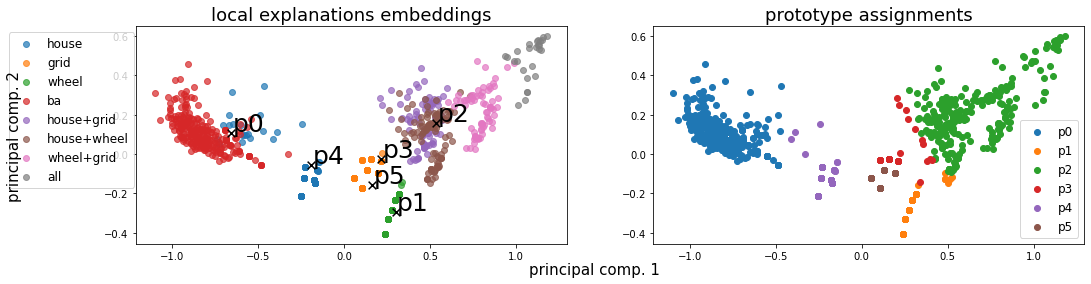

Alpha norms:
tensor([[0.4307, 0.3777, 1.0000, 0.4010, 0.2891, 0.4483],
        [0.0863, 0.1751, 1.0000, 0.1816, 0.1561, 0.1145]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.819484 +- 0.236371
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([267, 163, 262,  35, 105, 138], dtype=int64))
Logic formulas:
For class 0:
0.965 (feature001) | (feature000) | (feature005) | ((feature004) | (feature003)
For class 1:
0.965 (feature002) | (feature005 & feature004) | (feature005 & feature001) | (feature001 & feature003) | (feature004 & feature003) | (feature004 & feature001) | (feature005 & feature003) | (feature004 & feature002) | (feature001 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.965
LEN fidelity:  tensor(0.9650)


360: Loss: 0.00970, LEN: 0.009300, AccxC: 0.97, AccO: 0.97, V. Acc: 0.96, V. Loss: 0.01206, V. LEN 0.01
361: Loss: 0.01319, LEN: 0.012836, AccxC: 0.96, AccO: 0.96, V. Acc: 0.96, V. Loss: 0.01217, V. LEN 0.01
362: Loss: 0.01252, LE

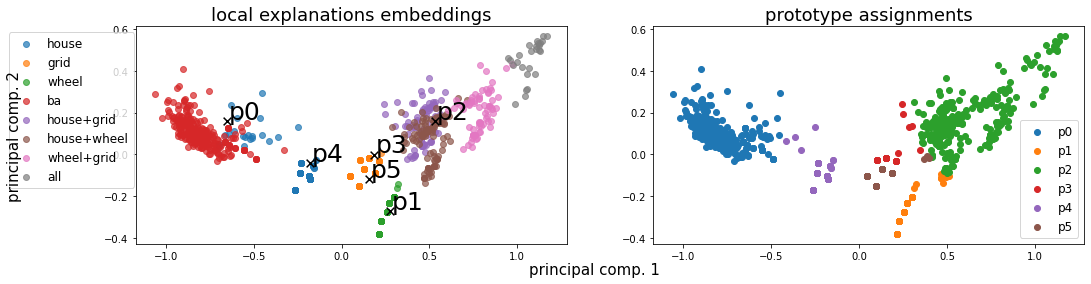

Alpha norms:
tensor([[0.4358, 0.3809, 1.0000, 0.3999, 0.2915, 0.4525],
        [0.0897, 0.1843, 1.0000, 0.1920, 0.1641, 0.1174]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.840451 +- 0.224707
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([267, 164, 264,  29, 105, 141], dtype=int64))
Logic formulas:
For class 0:
0.9675 (feature001) | (feature000) | (feature005) | ((feature004) | (feature003)
For class 1:
0.9675 (feature002) | (feature005 & feature004) | (feature005 & feature001) | (feature001 & feature003) | (feature004 & feature003) | (feature004 & feature001) | (feature004 & feature002) | (feature001 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.9675
LEN fidelity:  tensor(0.9675)


380: Loss: 0.01065, LEN: 0.010352, AccxC: 0.97, AccO: 0.97, V. Acc: 0.95, V. Loss: 0.01648, V. LEN 0.02
381: Loss: 0.01209, LEN: 0.011704, AccxC: 0.96, AccO: 0.96, V. Acc: 0.96, V. Loss: 0.01230, V. LEN 0.01
382: Loss: 0.00999, LEN: 0.009601, AccxC: 0.97,

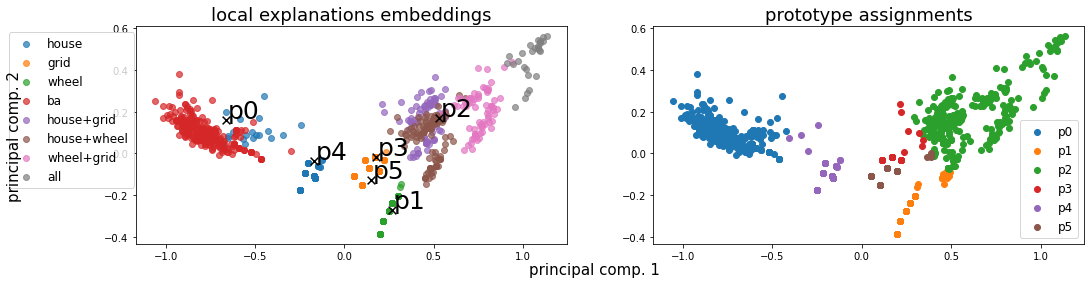

Alpha norms:
tensor([[0.4313, 0.3865, 1.0000, 0.3830, 0.2931, 0.4597],
        [0.0915, 0.1945, 1.0000, 0.1864, 0.1738, 0.1227]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.830685 +- 0.228696
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([267, 167, 260,  30, 105, 141], dtype=int64))
Logic formulas:
For class 0:
0.965 (feature001) | (feature000) | (feature005) | ((feature004) | (feature003)
For class 1:
0.965 (feature002) | (feature005 & feature004) | (feature005 & feature001) | (feature003 & feature001) | (feature004 & feature003) | (feature004 & feature001) | (feature004 & feature002) | (feature001 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.965
LEN fidelity:  tensor(0.9650)


400: Loss: 0.01018, LEN: 0.009863, AccxC: 0.97, AccO: 0.97, V. Acc: 0.95, V. Loss: 0.01492, V. LEN 0.01
401: Loss: 0.00918, LEN: 0.008915, AccxC: 0.97, AccO: 0.97, V. Acc: 0.97, V. Loss: 0.01146, V. LEN 0.01
402: Loss: 0.00975, LEN: 0.009406, AccxC: 0.97, Ac

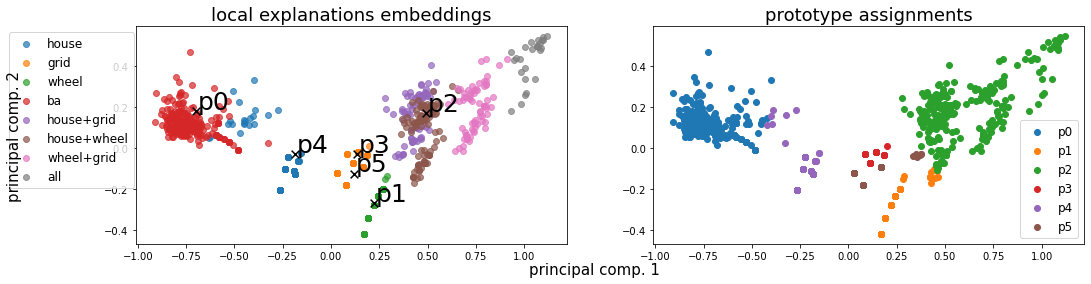

Alpha norms:
tensor([[0.4605, 0.4204, 1.0000, 0.4180, 0.3150, 0.4941],
        [0.1008, 0.2216, 1.0000, 0.2095, 0.1959, 0.1342]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.862628 +- 0.229405
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([264, 166, 264,  68, 108, 100], dtype=int64))
Logic formulas:
For class 0:
0.9725 (feature001) | (feature000) | (feature005) | ((feature004) | (feature003)
For class 1:
0.9725 (feature002) | (feature004 & feature003) | (feature005 & feature004) | (feature005 & feature001) | (feature003 & feature001) | (feature004 & feature001) | (feature004 & feature002) | (feature001 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.9725
LEN fidelity:  tensor(0.9725)


420: Loss: 0.01248, LEN: 0.012132, AccxC: 0.97, AccO: 0.97, V. Acc: 0.96, V. Loss: 0.01251, V. LEN 0.01
421: Loss: 0.01066, LEN: 0.010334, AccxC: 0.97, AccO: 0.98, V. Acc: 0.96, V. Loss: 0.01432, V. LEN 0.01
422: Loss: 0.01176, LEN: 0.011435, AccxC: 0.96,

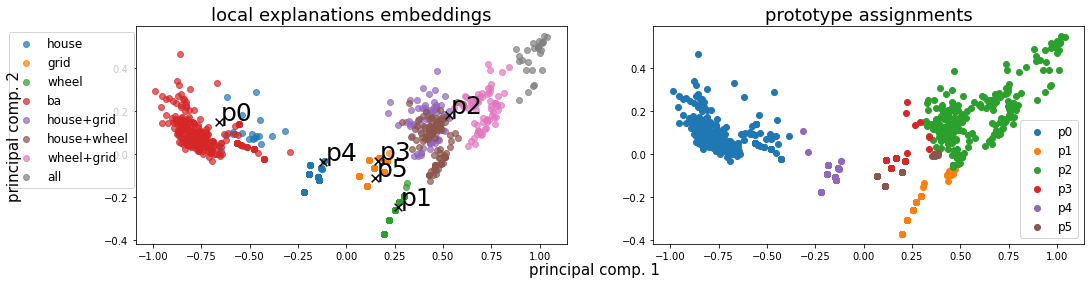

Alpha norms:
tensor([[0.4239, 0.3897, 1.0000, 0.3882, 0.2962, 0.4617],
        [0.0951, 0.2099, 1.0000, 0.1997, 0.1829, 0.1264]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.844167 +- 0.223778
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([269, 167, 257,  74, 103, 100], dtype=int64))
Logic formulas:
For class 0:
0.96375 (feature001) | (feature000) | (feature005) | ((feature004) | (feature003)
For class 1:
0.96375 (feature002) | (feature004 & feature003) | (feature005 & feature004) | (feature005 & feature001) | (feature003 & feature001) | (feature004 & feature001) | (feature004 & feature002) | (feature001 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.9638
LEN fidelity:  tensor(0.9638)


440: Loss: 0.00861, LEN: 0.008324, AccxC: 0.97, AccO: 0.98, V. Acc: 0.95, V. Loss: 0.01558, V. LEN 0.01
441: Loss: 0.00954, LEN: 0.009271, AccxC: 0.97, AccO: 0.97, V. Acc: 0.98, V. Loss: 0.00750, V. LEN 0.01
442: Loss: 0.01166, LEN: 0.011333, AccxC: 0.9

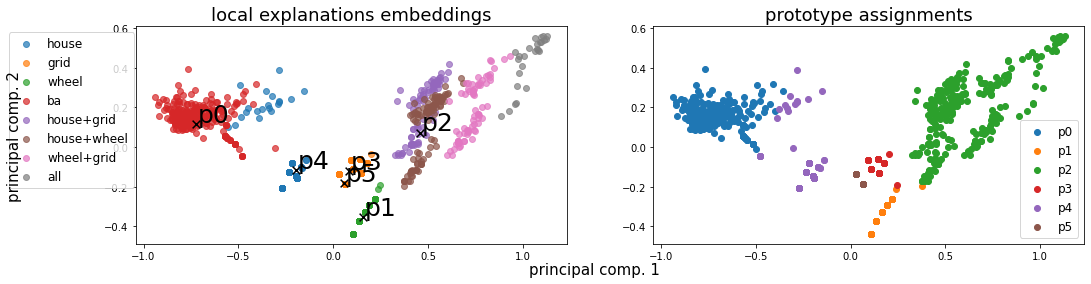

Alpha norms:
tensor([[0.4557, 0.4219, 1.0000, 0.4170, 0.3189, 0.5084],
        [0.1045, 0.2369, 1.0000, 0.2188, 0.2034, 0.1484]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.877578 +- 0.230623
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([253, 157, 278, 106, 119,  57], dtype=int64))
Logic formulas:
For class 0:
0.97875 (feature000) | (feature003) | (feature001) | ((feature004) | ((feature004 & feature000) | (feature005)
For class 1:
0.97875 (feature002) | (feature004 & feature003) | (feature005 & feature004) | (feature003 & feature001) | (feature005 & feature001) | (feature004 & feature001) | (feature005 & feature003) | (feature003 & feature002) | (feature004 & feature002) | (feature001 & feature002)
Accuracy as classifier:  0.9788
LEN fidelity:  tensor(0.9787)


460: Loss: 0.01067, LEN: 0.010248, AccxC: 0.97, AccO: 0.97, V. Acc: 0.98, V. Loss: 0.00821, V. LEN 0.01
461: Loss: 0.00967, LEN: 0.009356, AccxC: 0.97, AccO: 0.97, V. Acc: 0.95, V. Loss: 0.01388, 

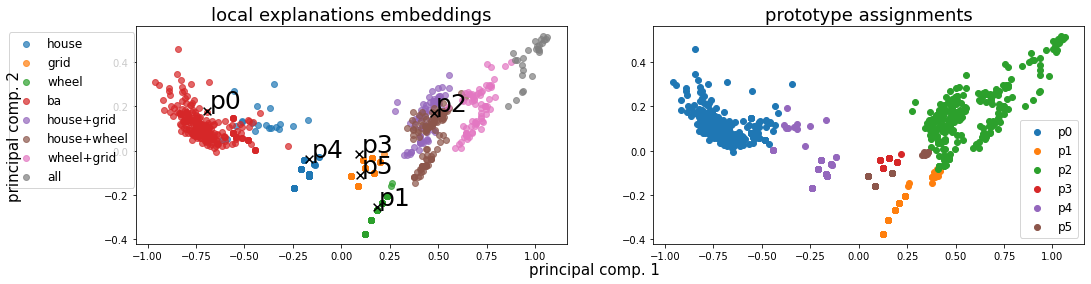

Alpha norms:
tensor([[0.4493, 0.4122, 1.0000, 0.4042, 0.3149, 0.4987],
        [0.1051, 0.2381, 1.0000, 0.2169, 0.2005, 0.1465]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.855873 +- 0.227237
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([256, 167, 263,  68, 116, 100], dtype=int64))
Logic formulas:
For class 0:
0.97125 (feature001) | (feature000) | (feature005) | ((feature004) | ((feature004 & feature000) | (feature003)
For class 1:
0.97125 (feature002) | (feature004 & feature003) | (feature005 & feature004) | (feature005 & feature001) | (feature003 & feature001) | (feature004 & feature001) | (feature004 & feature002) | (feature001 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.9712
LEN fidelity:  tensor(0.9712)


480: Loss: 0.01089, LEN: 0.010583, AccxC: 0.97, AccO: 0.97, V. Acc: 0.96, V. Loss: 0.01263, V. LEN 0.01
481: Loss: 0.00993, LEN: 0.009669, AccxC: 0.97, AccO: 0.97, V. Acc: 0.95, V. Loss: 0.01411, V. LEN 0.01
482: Loss: 0.010

In [14]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 6,
    "dim_prototypes": 10,
    "num_le_features": 5,
    "embedder_backbone": "GIN",
    "embedder_num_layers": 2,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": False,
    "log_models": True,
    "num_epochs": 2000
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
expl         = models.GlobalExplainer(len_model, 
                               le_model, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=bamultishapes_classes_names,
                               dataset_name=DATASET_NAME).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
suffix = "no attn" if hyper["remove_attention"] else ""
expl.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=f"MShapes2 {hyper['num_prototypes']}prots {prefix} {suffix}")

(array([0., 1., 2., 3., 4., 5., 6.], dtype=float32), array([17, 21, 18, 33,  9, 11, 11], dtype=int64))


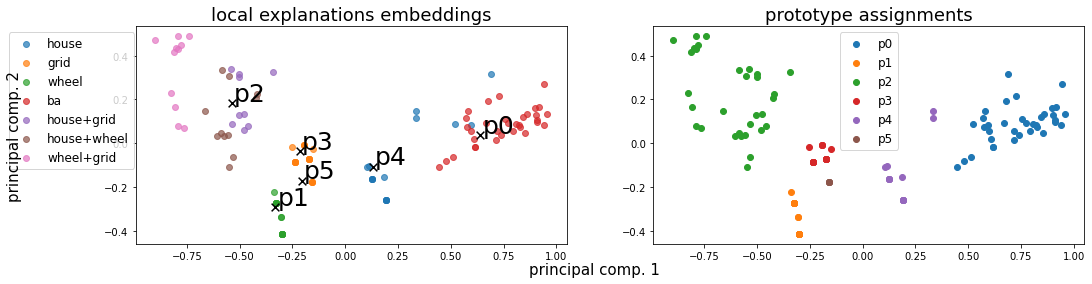

Alpha norms:
tensor([[0.4375, 0.3889, 1.0000, 0.3983, 0.2960, 0.4619],
        [0.0924, 0.1938, 1.0000, 0.1937, 0.1743, 0.1225]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.878584 +- 0.236194
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([36, 18, 31, 17, 14,  4], dtype=int64))
Logic formulas:
For class 0:
0.98 (feature000) | (feature001) | ((feature004) | (feature003)
For class 1:
0.98 (feature002) | (feature004 & feature003) | (feature003 & feature001) | (feature005 & feature004) | (feature004 & feature001) | (feature005 & feature001)
Accuracy as classifier:  0.98
LEN fidelity:  tensor(0.9800)



In [16]:
expl.inspect_embedding(test_group_loader)

In [26]:
expl.train_metrics[565]

{'loss': 0.00966600887477398,
 'acc_per_class': 0.9787798408488063,
 'acc_overall': tensor(0.9788),
 'len_loss': 0.009369286708533764,
 'logic_loss': 0.0,
 'prototype_distance_loss': 0.0,
 'r1_loss:': 0.0002458486123941839,
 'r2_loss:': 5.0874008593382314e-05,
 'div_loss:': 0.0,
 'debug_loss:': 0.0,
 'concept_entropy_loss:': 0.0,
 'distribution_entropy_loss:': 0.0,
 'temperature': 1.0,
 'cluster_acc_mean': 0.8328355432109981,
 'cluster_acc_std': 0.20824889865505317,
 'concept_vector_entropy': tensor(0., grad_fn=<MeanBackward0>),
 'prototype_assignements': <wandb.sdk.data_types.Histogram at 0x1fa331d5888>,
 'concept_vector': <wandb.sdk.data_types.Histogram at 0x1fa331d5608>}

(array([0., 1., 2., 3., 4., 5., 6.], dtype=float32), array([17, 21, 18, 33,  9, 11, 11], dtype=int64))


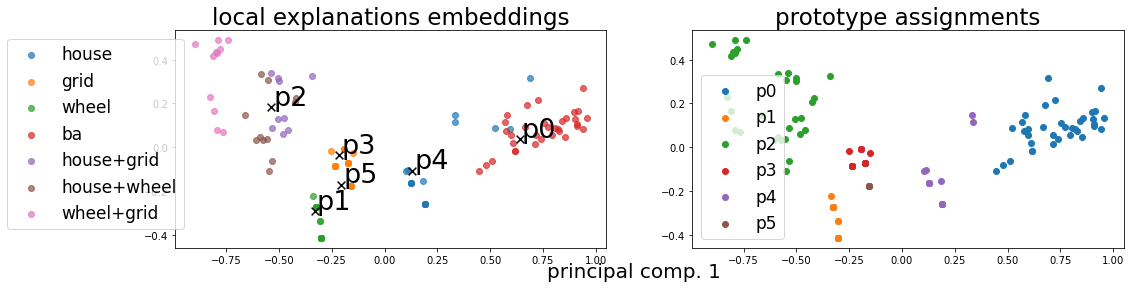

Alpha norms:
tensor([[0.4375, 0.3889, 1.0000, 0.3983, 0.2960, 0.4619],
        [0.0924, 0.1938, 1.0000, 0.1937, 0.1743, 0.1225]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.878584 +- 0.236194
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([36, 18, 31, 17, 14,  4], dtype=int64))
Logic formulas:
For class 0:
0.98 (feature000) | (feature001) | ((feature004) | (feature003)
For class 1:
0.98 (feature002) | (feature004 & feature003) | (feature003 & feature001) | (feature005 & feature004) | (feature004 & feature001) | (feature005 & feature001)
Accuracy as classifier:  0.98
LEN fidelity:  tensor(0.9800)



In [8]:
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 6,
    "dim_prototypes": 10,
    "num_le_features": 5,
    "embedder_backbone": "GIN",
    "embedder_num_layers": 2,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": False,
    "num_epochs": 2000
}
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)

len_model2    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model2     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
best_expl         = models.GlobalExplainer(len_model2, 
                               le_model2, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=bamultishapes_classes_names,
                               dataset_name=DATASET_NAME).to(device)
best_expl.load_state_dict(torch.load("../trained_models/BAMultiShapes_allsamples.pt"))
best_expl.eval()

best_expl.inspect_embedding(test_group_loader)

### materialize prototypes

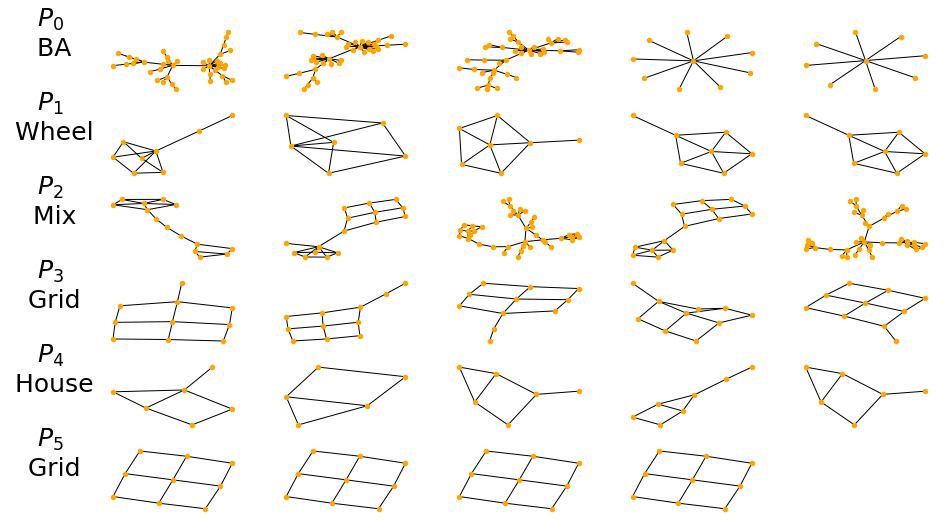

In [12]:
best_expl.eval()
x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs , belonging = best_expl.get_concept_vector(test_group_loader, 
                                                                                                                    return_raw=True)        
proto_names = {
    0: "BA",
    1: "Wheel",
    2: "Mix",
    3: "Grid",
    4: "House",
    5: "Grid",
}
torch.manual_seed(42)
fig = plt.figure(figsize=(15,5*1.8))
n = 0
for p in range(best_expl.hyper["num_prototypes"]):
    idxs = le_idxs[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.randperm(len(idxs))]    
    for ex in range(min(5, len(idxs))):
        n += 1
        ax = plt.subplot(best_expl.hyper["num_prototypes"],5,n)      
        G = to_networkx(dataset_test[int(idxs[ex])], to_undirected=True)
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, node_size=20, ax=ax, node_color="orange")
        ax.axis("on")
        plt.box(False)
        
for p in range(best_expl.hyper["num_prototypes"]):
    plt.subplot(best_expl.hyper["num_prototypes"],5,5*p + 1)
    plt.ylabel(f"$P_{p}$\n {proto_names[p]}", size=25, rotation="horizontal", labelpad=50)

plt.savefig("prototypes_bamultishapes.pdf")
plt.show() 

# MUTAG

In [15]:
DATASET_NAME = "Mutag"

In [16]:
adjs_train , \
edge_weights_train , \
ori_adjs_train , \
ori_classes_train , \
belonging_train , \
summary_predictions_train , \
le_classes_train ,\
embeddings_train = read_mutagenicity(evaluate_method=False, 
                                     manual_cut=0.37731856, #0.42392886
                                     split="TRAIN")

print(np.unique(le_classes_train, return_counts=True))

belonging_train2 = np.array(belonging_train)
le_classes_train = np.array(le_classes_train)
c = 0
for b in np.unique(belonging_train):
    if ori_classes_train[b] == 1 and 0 in le_classes_train[belonging_train2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_train))
c = 0
for b in np.unique(belonging_train):
    if ori_classes_train[b] == 0 and 0 not in le_classes_train[belonging_train2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_train))

print(len(adjs_train) , len(edge_weights_train), len(ori_adjs_train) , len(ori_classes_train) , len(belonging_train))
np.unique(summary_predictions_train["wrong"], return_counts=True) , np.unique(summary_predictions_train["correct"], return_counts=True)

This is a NH2 local explanation
This is a NH2 local explanation
(array([0, 1]), array([675, 451], dtype=int64))
Samples of class 1 containing NO2:  0.050188205771643665
Samples of class 0 not containing NO2:  0.13801756587202008
1126 1126 797 797 1126


((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1]), array([1921, 1548], dtype=int64)))

In [17]:
adjs_val , \
edge_weights_val , \
ori_adjs_val , \
ori_classes_val , \
belonging_val , \
summary_predictions_val , \
le_classes_val ,\
embeddings_val = read_mutagenicity(evaluate_method=False, 
                                   manual_cut=0.37731856,
                                   split="VAL")

print(np.unique(le_classes_val, return_counts=True))

belonging_val2 = np.array(belonging_val)
le_classes_val = np.array(le_classes_val)
c = 0
for b in np.unique(belonging_val):
    if ori_classes_val[b] == 1 and 0 in le_classes_val[belonging_val2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_val))
c = 0
for b in np.unique(belonging_val):
    if ori_classes_val[b] == 0 and 0 not in le_classes_val[belonging_val2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_val))

print(len(adjs_val) , len(edge_weights_val), len(ori_adjs_val) , len(ori_classes_val) , len(belonging_val))
np.unique(summary_predictions_val["wrong"], return_counts=True) , np.unique(summary_predictions_val["correct"], return_counts=True)

(array([0, 1]), array([93, 62], dtype=int64))
Samples of class 1 containing NO2:  0.01904761904761905
Samples of class 0 not containing NO2:  0.17142857142857143
155 155 105 105 155


((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1]), array([245, 189], dtype=int64)))

In [18]:
adjs_test , \
edge_weights_test , \
ori_adjs_test , \
ori_classes_test , \
belonging_test , \
summary_predictions_test , \
le_classes_test ,\
embeddings_test = read_mutagenicity(evaluate_method=False, 
                                   manual_cut=0.37731856,
                                   split="TEST")

print(np.unique(le_classes_test, return_counts=True))

belonging_test2 = np.array(belonging_test)
le_classes_test = np.array(le_classes_test)
c = 0
for b in np.unique(belonging_test):
    if ori_classes_test[b] == 1 and 0 in le_classes_test[belonging_test2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_test))
c = 0
for b in np.unique(belonging_test):
    if ori_classes_test[b] == 0 and 0 not in le_classes_test[belonging_test2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_test))

print(len(adjs_test) , len(edge_weights_test), len(ori_adjs_test) , len(ori_classes_test) , len(belonging_test))
np.unique(summary_predictions_test["wrong"], return_counts=True) , np.unique(summary_predictions_test["correct"], return_counts=True)

(array([0, 1]), array([74, 65], dtype=int64))
Samples of class 1 containing NO2:  0.02040816326530612
Samples of class 0 not containing NO2:  0.17346938775510204
139 139 98 98 139


((array([], dtype=float64), array([], dtype=int64)),
 (array([0, 1]), array([235, 199], dtype=int64)))

C:\Users\Steve\Desktop\GNN\gnn_logic_global_expl\code\utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr=torch.tensor(t.weight).reshape(-1, 1),


(array([0, 1]), array([675, 451], dtype=int64))
(tensor([0, 1]), tensor([837, 289]))


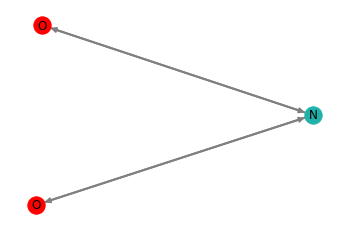

(15, tensor([15]))

In [19]:
device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = None  

dataset_train = utils.LocalExplanationsDataset("", adjs_train, edge_weights_test, "embeddings", transform=transform, y=le_classes_train, belonging=belonging_train, task_y=ori_classes_train, precomputed_embeddings=embeddings_train)
dataset_val = utils.LocalExplanationsDataset("", adjs_val, edge_weights_val, "embeddings", transform=transform, y=le_classes_val, belonging=belonging_val, task_y=ori_classes_val, precomputed_embeddings=embeddings_val)
dataset_test = utils.LocalExplanationsDataset("", adjs_test, edge_weights_test, "embeddings", transform=transform, y=le_classes_test, belonging=belonging_test, task_y=ori_classes_test, precomputed_embeddings=embeddings_test)


##
# debug Dataset
##
print(np.unique(le_classes_train, return_counts=True))
print(torch.unique(dataset_train.data.task_y, return_counts=True))
idx = 18
utils.plot_molecule(dataset_train[idx])
belonging_train[idx] , dataset_train[idx].graph_id

(array([0., 1.], dtype=float32), array([675, 451], dtype=int64))


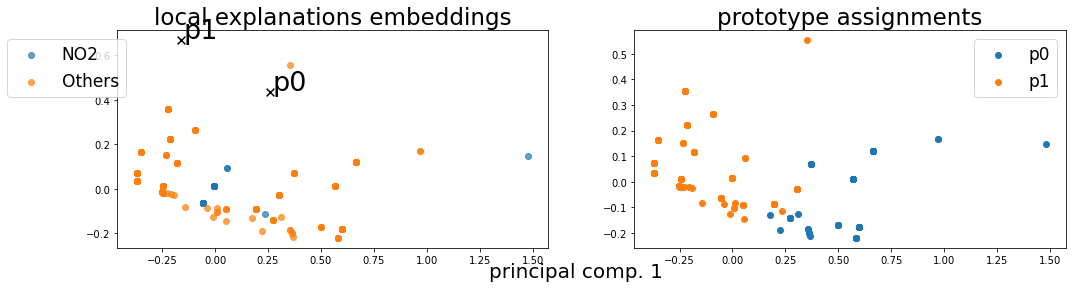

Alpha norms:
tensor([[1.0000, 0.6722],
        [0.7495, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.848798 +- 0.145249
Concept distribution:  (array([0, 1], dtype=int64), array([168, 958], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1: Loss: 0.16989, LEN: 0.067595, AccxC: 0.25, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.19363, V. LEN 0.09
  2: Loss: 0.14086, LEN: 0.067325, AccxC: 0.75, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.17273, V. LEN 0.09
  3: Loss: 0.11928, LEN: 0.067069, AccxC: 0.75, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.14272, V. LEN 0.09
  4: Loss: 0.09616, LEN: 0.066912, AccxC: 0.75, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.11128, V. LEN 0.09
  5: Loss: 0.07833, LEN: 0.066654, AccxC: 0.75, AccO: 0.00, V. Acc: 0.73, V. Loss: 0.09401, V. LEN 0.09
  6: Loss: 0.07412, LEN: 0.066507, AccxC: 0.75, AccO: 0.60, V. Acc: 0.74, V. Loss: 0.09119, V. LEN 0.08
  7: Loss: 0.07397, LEN: 0.066379, AccxC: 0.75, AccO:

 77: Loss: 0.04404, LEN: 0.043690, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05659, V. LEN 0.05
 78: Loss: 0.04217, LEN: 0.041837, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05608, V. LEN 0.05
 79: Loss: 0.04329, LEN: 0.042926, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05513, V. LEN 0.05


 80: Loss: 0.04240, LEN: 0.042031, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05543, V. LEN 0.05
 81: Loss: 0.04296, LEN: 0.042602, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05531, V. LEN 0.05
 82: Loss: 0.04180, LEN: 0.041400, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05443, V. LEN 0.05
 83: Loss: 0.04218, LEN: 0.041701, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05444, V. LEN 0.05
 84: Loss: 0.04267, LEN: 0.042256, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05331, V. LEN 0.05
 85: Loss: 0.04282, LEN: 0.042346, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.05365, V. LEN 0.05
 86: Loss: 0.04566, LEN: 0.045236, AccxC: 0.81, AccO: 0.81, V.

156: Loss: 0.04051, LEN: 0.040264, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05166, V. LEN 0.05
157: Loss: 0.04062, LEN: 0.040320, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05215, V. LEN 0.05
158: Loss: 0.04103, LEN: 0.040732, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05259, V. LEN 0.05
159: Loss: 0.04380, LEN: 0.043438, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.05240, V. LEN 0.05


160: Loss: 0.03942, LEN: 0.039019, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05378, V. LEN 0.05
161: Loss: 0.04030, LEN: 0.040011, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05200, V. LEN 0.05
162: Loss: 0.03837, LEN: 0.038065, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05210, V. LEN 0.05
163: Loss: 0.04117, LEN: 0.040819, AccxC: 0.81, AccO: 0.81, V. Acc: 0.82, V. Loss: 0.05254, V. LEN 0.05
164: Loss: 0.04107, LEN: 0.040731, AccxC: 0.82, AccO: 0.82, V. Acc: 0.82, V. Loss: 0.05323, V. LEN 0.05
165: Loss: 0.03976, LEN: 0.039533, AccxC: 0.81, AccO: 0.81, V.

235: Loss: 0.04229, LEN: 0.041973, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05527, V. LEN 0.05
236: Loss: 0.04169, LEN: 0.041364, AccxC: 0.81, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.05622, V. LEN 0.05
237: Loss: 0.04135, LEN: 0.041091, AccxC: 0.81, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.05562, V. LEN 0.05
238: Loss: 0.04131, LEN: 0.041046, AccxC: 0.82, AccO: 0.82, V. Acc: 0.80, V. Loss: 0.05592, V. LEN 0.05
239: Loss: 0.04054, LEN: 0.040224, AccxC: 0.81, AccO: 0.81, V. Acc: 0.80, V. Loss: 0.05617, V. LEN 0.05


240: Loss: 0.04008, LEN: 0.039846, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05535, V. LEN 0.05
241: Loss: 0.03993, LEN: 0.039656, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05503, V. LEN 0.05
242: Loss: 0.04095, LEN: 0.040674, AccxC: 0.81, AccO: 0.81, V. Acc: 0.81, V. Loss: 0.05501, V. LEN 0.05
243: Loss: 0.04133, LEN: 0.041085, AccxC: 0.82, AccO: 0.82, V. Acc: 0.81, V. Loss: 0.05521, V. LEN 0.05
244: Loss: 0.04110, LEN: 0.040858, AccxC: 0.82, AccO: 0.82, V.

FileNotFoundError: [Errno 2] No such file or directory: '../logs/ablation/num_proto/Mutag/2_train_metrics.pkl'

In [24]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 2,
    "dim_prototypes": 10,
    "num_le_features": 14,
    "embedder_backbone": "GIN",
    "embedder_num_layers": 2,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": True,
    "num_epochs": 500
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
expl         = models.GlobalExplainer(len_model, 
                               le_model, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=mutag_classes_names,
                               dataset_name=DATASET_NAME).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
suffix = "no attn" if hyper["remove_attention"] else ""
expl.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=f"MUTAG {hyper['num_prototypes']}prots {prefix} {suffix}")

In [ ]:
expl.inspect_embedding(test_group_loader)

(array([0., 1.], dtype=float32), array([74, 65], dtype=int64))


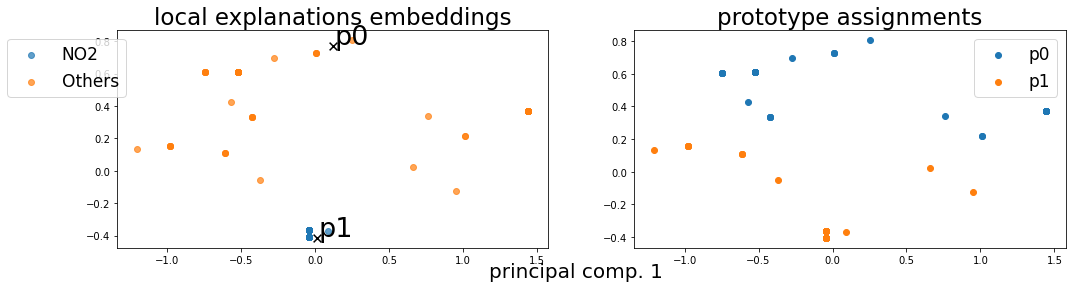

Alpha norms:
tensor([[1.0000, 0.9776],
        [0.4050, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.930233 +- 0.069767
Concept distribution:  (array([0, 1], dtype=int64), array([53, 86], dtype=int64))
Logic formulas:
For class 0:
0.826530612244898 ((feature001) | ((feature001 & feature000)
For class 1:
0.826530612244898 ((feature000)
Accuracy as classifier:  0.8265
LEN fidelity:  tensor(0.8265)



In [27]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 2,
    "dim_prototypes": 10,
    "num_le_features": 14,
    "embedder_backbone": "GIN",
    "embedder_num_layers": 2,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": True,
    "num_epochs": 500
}


len_model2    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model2     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
best_expl_mutag         = models.GlobalExplainer(len_model2, 
                               le_model2, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=mutag_classes_names,
                               dataset_name=DATASET_NAME).to(device)
best_expl_mutag.load_state_dict(torch.load("../trained_models/Mutagenicity_allsamples.pt"))
best_expl_mutag.eval()

best_expl_mutag.inspect_embedding(test_group_loader)

### materialize prototypes

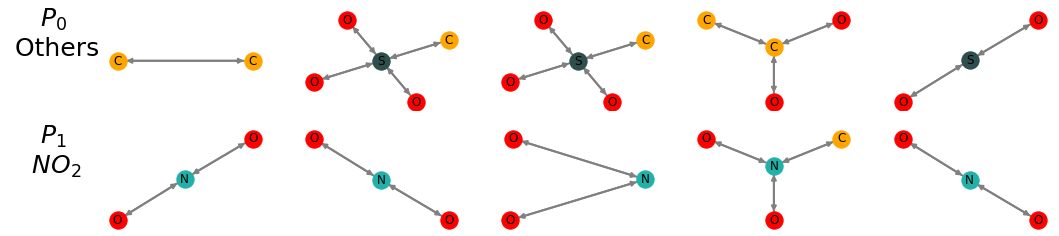

In [25]:
best_expl_mutag.eval()
x_train , emb , concepts_assignement , y_train_1h , le_classes , le_idxs , belonging = best_expl_mutag.get_concept_vector(train_group_loader, 
                                                                                                               return_raw=True)        
proto_names = {
    0: "Others",
    1: "$NO_2$",
}
torch.manual_seed(42)
fig = plt.figure(figsize=(17,4))
n = 0
for p in range(best_expl_mutag.hyper["num_prototypes"]):
    idxs = le_idxs[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.randperm(len(idxs))]
    
    for ex in range(5):
        n += 1
        plt.subplot(best_expl_mutag.hyper["num_prototypes"],5,n)        
        #G = to_networkx(dataset_train[int(idx)])
        #nx.draw(G, node_size=50)
        utils.plot_molecule(dataset_train[int(idxs[ex])], composite_plot=True)

for p in range(expl.hyper["num_prototypes"]):
    plt.subplot(expl.hyper["num_prototypes"],5,5*p + 1)
    plt.ylabel(f"$P_{p}$\n {proto_names[p]}", size=25, rotation="horizontal", labelpad=50)
plt.savefig("prototypes_mutagenicity.pdf")
plt.show() 